# ОИАД. Лабораторная работа №3

## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)

## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [1]:
import numpy as np
import pandas as pd

def load_data(train_path='insurance_train.csv', test_path='insurance_test.csv'):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

train_df, test_df = load_data()
print(train_df)

     age     sex     bmi  children smoker     region      charges
0     26    male  27.060         0    yes  southeast  17043.34140
1     58    male  36.955         2    yes  northwest  47496.49445
2     20  female  24.420         0    yes  southeast  26125.67477
3     51  female  38.060         0    yes  southeast  44400.40640
4     62  female  25.000         0     no  southwest  13451.12200
..   ...     ...     ...       ...    ...        ...          ...
333   25  female  22.515         1     no  northwest   3594.17085
334   18    male  53.130         0     no  southeast   1163.46270
335   64    male  37.905         0     no  northwest  14210.53595
336   54  female  47.410         0    yes  southeast  63770.42801
337   28  female  25.800         0     no  southwest   3161.45400

[338 rows x 7 columns]


# 1. Подготовка данных
1. проверить наличие пропусков и выбросов

In [2]:
def inspect_data(df):
    print("\nMissing values per column:\n", df.isna().sum())
    num = df.select_dtypes(include=[np.number])
    for col in num.columns:
        Q1 = num[col].quantile(0.25)
        Q3 = num[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        n_out = ((num[col] < lower) | (num[col] > upper)).sum()
        if n_out > 0:
            print(f"Outliers in {col}: {n_out} out of {len(df)}")

inspect_data(train_df)
inspect_data(test_df)


Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Outliers in bmi: 5 out of 338
Outliers in charges: 19 out of 338

Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Outliers in bmi: 4 out of 1000
Outliers in charges: 112 out of 1000


2. привести категориальные признаки к числовым

In [3]:
def get_categorical_columns(df):
    return df.select_dtypes(include=['object', 'category']).columns.tolist()

print(get_categorical_columns(train_df))


['sex', 'smoker', 'region']


In [4]:
def label_encode(df, cat_cols = None):
    if cat_cols is None:
        cat_cols = get_categorical_columns(df)
    df2 = df.copy()
    mappings = {}
    for col in cat_cols:
        df2[col] = df2[col].astype('category')
        mapping = {cat: code for code, cat in enumerate(df2[col].cat.categories)}
        df2[col] = df2[col].cat.codes
        mappings[col] = mapping
    return df2, mappings

def one_hot_encode(df, cat_cols = None, drop_first = True):
    if cat_cols is None:
        cat_cols = get_categorical_columns(df)
    df2 = df.copy()
    df2 = pd.get_dummies(df2, columns=cat_cols, drop_first=drop_first,  dtype=int)
    return df2

#train_df_2 = one_hot_encode(train_df)
#test_df_2 = one_hot_encode(test_df)
train_df_2, mappings = label_encode(train_df)
test_df_2, mappings = label_encode(test_df)
print(train_df_2)
print(mappings)

     age  sex     bmi  children  smoker  region      charges
0     26    1  27.060         0       1       2  17043.34140
1     58    1  36.955         2       1       1  47496.49445
2     20    0  24.420         0       1       2  26125.67477
3     51    0  38.060         0       1       2  44400.40640
4     62    0  25.000         0       0       3  13451.12200
..   ...  ...     ...       ...     ...     ...          ...
333   25    0  22.515         1       0       1   3594.17085
334   18    1  53.130         0       0       2   1163.46270
335   64    1  37.905         0       0       1  14210.53595
336   54    0  47.410         0       1       2  63770.42801
337   28    0  25.800         0       0       3   3161.45400

[338 rows x 7 columns]
{'sex': {'female': 0, 'male': 1}, 'smoker': {'no': 0, 'yes': 1}, 'region': {'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}}


In [5]:
def compute_correlations(df, method = 'pearson'):
    #method{‘pearson’, ‘kendall’, ‘spearman’} or callable
    num_df = df.select_dtypes(include=[np.number])
    corr = num_df.corr(method=method)
    return corr

#===============================================
pd.options.display.float_format = '{:.2f}'.format
#===============================================

print("Pearson")
print(compute_correlations(train_df_2))
print("Kendall")
print(compute_correlations(train_df_2, 'kendall'))
print("Spearman")
print(compute_correlations(train_df_2, 'spearman'))


Pearson
           age   sex  bmi  children  smoker  region  charges
age       1.00 -0.05 0.08      0.05    0.01    0.02     0.30
sex      -0.05  1.00 0.04     -0.01    0.12   -0.05     0.06
bmi       0.08  0.04 1.00      0.06    0.05    0.20     0.22
children  0.05 -0.01 0.06      1.00   -0.00    0.03     0.07
smoker    0.01  0.12 0.05     -0.00    1.00   -0.08     0.78
region    0.02 -0.05 0.20      0.03   -0.08    1.00    -0.07
charges   0.30  0.06 0.22      0.07    0.78   -0.07     1.00
Kendall
           age   sex  bmi  children  smoker  region  charges
age       1.00 -0.04 0.06      0.06    0.01    0.02     0.45
sex      -0.04  1.00 0.02     -0.00    0.12   -0.04     0.00
bmi       0.06  0.02 1.00      0.05    0.05    0.15     0.10
children  0.06 -0.00 0.05      1.00    0.00    0.01     0.12
smoker    0.01  0.12 0.05      0.00    1.00   -0.07     0.56
region    0.02 -0.04 0.15      0.01   -0.07    1.00    -0.08
charges   0.45  0.00 0.10      0.12    0.56   -0.08     1.00
Spearman

# Можно предположить что сильную корелляцию имеют только параметры smoker и charges

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)

In [6]:
def prepare_data(df):
    y = df['charges'].values

    X = df.drop(columns=['charges']).copy()

    return X, y

train_preped, y = prepare_data(train_df_2)
test_preped, y_test = prepare_data(test_df_2)

In [7]:
def normal_equation(X, y):
    #w = (X^T X)^(-1) X^T y
    XT = X.T 
    w = np.linalg.inv(XT @ X) @ XT @ y
    return w

w_analytic = normal_equation(train_preped, y)
print(w_analytic)

0     194.50
1   -1348.18
2      95.11
3     332.09
4   23220.30
5    -706.96
dtype: float64


# Оценка модели

In [8]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

y_pred_analytic = test_preped.values @ w_analytic

mse_analytic = mse(y_test, y_pred_analytic)
print("=== Analytical ===")
print("MSE:", round(mse_analytic, 2))

=== Analytical ===
MSE: 38552517.24


In [9]:
def gradient_descent(X, y, lr = 1e-5, n_iter = 10000):
    n, d = X.shape
    w = np.zeros(d)
    losses = []

    for i in range(n_iter):
        y_pred = X @ w
        error = y_pred - y
        grad = (2/n) * X.T @ error
        w -= lr * grad
        loss = (error**2).mean()
        losses.append(loss)

        if i % (n_iter // 5) == 0:
            print(f"Iter {i:5d}: loss={loss:.4f}")

    return w, losses

w_gd, losses = gradient_descent(train_preped, y, lr=0.0001, n_iter=20000)
print(w_gd)
y_pred_gd = test_preped @ w_gd
mse_gd = mse(y_test, y_pred_gd)
print("\n=== Gradient ===")
print("MSE на тесте:", round(mse_gd, 2))
print("Последний loss на train:", round(losses[-1], 2))

Iter     0: loss=361771951.7876
Iter  4000: loss=119191470.5594
Iter  8000: loss=101598760.6219
Iter 12000: loss=88594970.5083
Iter 16000: loss=78818518.2153
age          204.45
sex          157.97
bmi          163.49
children     341.00
smoker     11653.29
region     -1127.00
dtype: float64

=== Gradient ===
MSE на тесте: 61509516.98
Последний loss на train: 71434262.35


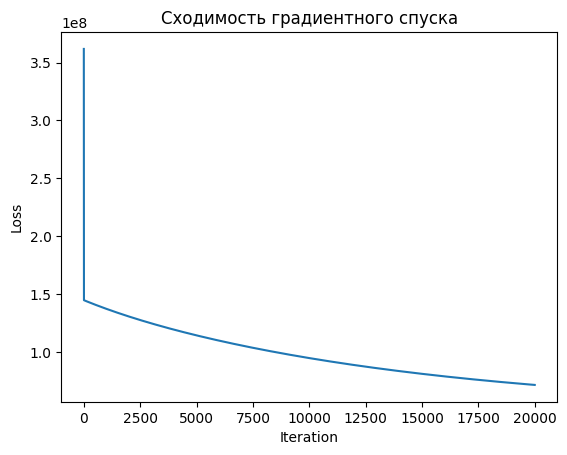

In [10]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Сходимость градиентного спуска")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:

аналитически

численно

In [11]:
def regularization_analytic(X, y, alpha = 1.0):

    n, d = X.shape
    Xb = np.hstack([np.ones((n, 1)), X])  
    D = Xb.shape[1]
    I = np.eye(D)
    I[0, 0] = 0.0 
        
    w = np.linalg.pinv(Xb.T @ Xb + alpha * I) @ (Xb.T @ y)
    return w

In [12]:
w_regular_analytic = regularization_analytic(train_preped, y, alpha=0.5)

In [13]:
print(w_regular_analytic)
n = test_preped.shape[0]
test_preped_b = np.hstack([np.ones((n,1)), test_preped])
y_pred_regular_analytic = test_preped_b @ w_regular_analytic
mse_analytic_reg = mse(y_test, y_pred_regular_analytic)
print("=== Analytical with regularization ===")
print("MSE:", round(mse_analytic_reg, 2))

[-11044.9756211     257.43110354   -646.43327025    339.50079852
    481.87623244  23202.17010645   -554.80088453]
=== Analytical with regularization ===
MSE: 34239386.7


# MSE с регуляризацией стало меньше чем без регуляризации

In [14]:
def regularization_gradient_descent(X, y, alpha=1.0, lr=1e-5, n_iter=10000):
    n, d = X.shape
    # Добавляем столбец единиц для bias (intercept)
    X_with_bias = np.hstack([np.ones((n, 1)), X])
    D = X_with_bias.shape[1]  # новая размерность (d + 1)
    w = np.zeros(D)
    losses = []

    for i in range(n_iter):
        # Прямое распространение
        y_pred = X_with_bias @ w
        error = y_pred - y
        
        # Функция потерь с L2 регуляризацией (исключая bias)
        loss = (error**2).mean() + alpha * (w[1:]**2).mean()
        losses.append(loss)
        
        # Градиент
        grad = (2/n) * X_with_bias.T @ error
        # Добавляем регуляризацию только для весов (не для bias)
        grad_reg = 2 * alpha * np.hstack([0, w[1:]]) / n
        grad += grad_reg
        
        w -= lr * grad

        if i % (n_iter // 5) == 0:
            print(f"Iter {i:5d}: loss={loss:.4f}")

    return w, losses

In [15]:
w_gd_reg, losses2 = regularization_gradient_descent(train_preped, y, alpha=0.1, lr=1e-4, n_iter=100000)

Iter     0: loss=361771951.7876
Iter 20000: loss=73065304.3412
Iter 40000: loss=57856224.8514
Iter 60000: loss=54733448.1108
Iter 80000: loss=54202705.5572


In [16]:
print(w_gd_reg)
n = test_preped.shape[0]
test_preped_b = np.hstack([np.ones((n,1)), test_preped])
y_pred_regular_grad = test_preped_b @ w_gd_reg
mse_grad_reg = mse(y_test, y_pred_regular_grad)
print("=== Gradient with regularization ===")
print("MSE:", round(mse_grad_reg, 2))

[-4907.11720579   223.06253629  -899.75759775   207.35806361
   397.4682338  22500.02492232  -667.42364509]
=== Gradient with regularization ===
MSE: 35905100.56


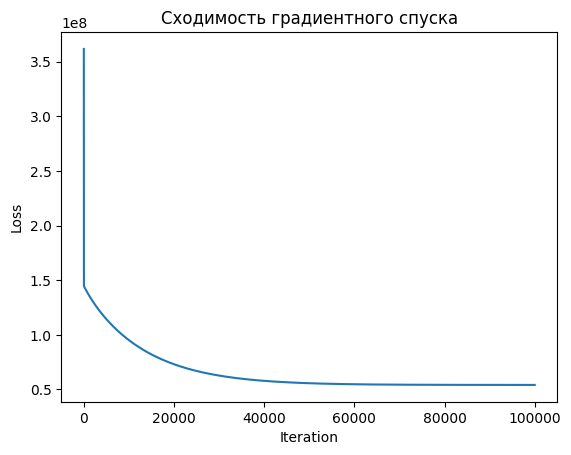

In [17]:
import matplotlib.pyplot as plt
plt.plot(losses2)
plt.title("Сходимость градиентного спуска")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [18]:
def baseline_constant_mse(y_train, y_test):
    y_pred = np.full_like(y_test, y_train.mean())
    mse1 = mse(y_test, y_pred)
    return mse1

mse_baseline = baseline_constant_mse(y, y_test)
print(mse_baseline)

141830094.35903943


In [19]:
print("=== Оценка моделей по MSE ===")
print(f"Константная модель: {mse_baseline:,.4f}")
print(f"Линейная регрессия аналитически: {mse_analytic:,.4f}")
print(f"Линейная регрессия градиентный спуск: {mse_gd:,.4f}")
print(f"Линейная регрессия аналитически с регуляризацией: {mse_analytic_reg:,.4f}")
print(f"Линейная регрессия градиентный спуск с регуляризацией: {mse_grad_reg:,.4f}")

=== Оценка моделей по MSE ===
Константная модель: 141,830,094.3590
Линейная регрессия аналитически: 38,552,517.2352
Линейная регрессия градиентный спуск: 61,509,516.9842
Линейная регрессия аналитически с регуляризацией: 34,239,386.6966
Линейная регрессия градиентный спуск с регуляризацией: 35,905,100.5554
